This script was used to split the cleaned dataset into training, validation, and test set (based on the date of a report), ensuring that all datasets have the same morphology classes.

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold

from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from global_variables import RANDOM_SEED
from datetime import datetime

###
from functions_small_helper import create_folder_if_not_exists, get_sorted_labels_of_column, plot_column_count

In [2]:
# input
# file without any duplicates
data_folder = os.path.join("..", "data", "data_clean")
data_filename = "data_clean_no_dup.pkl"
data_file = os.path.join(data_folder, data_filename)
df = pd.read_pickle(data_file).reset_index(drop=True)
df["morphology"] = df["morphology"].astype("int")
df["histology"] = df["histology"].astype("int")
df["behavior"] = df["behavior"].astype("int")

In [3]:
# input
# file for testsets with partial duplicates --> idea in the beginning to explore further, but was not proceeded further
data_part_dup_filename = "data_clean_part_dup.pkl"
data_part_dup_file = os.path.join(data_folder, data_part_dup_filename)
df_partdup = pd.read_pickle(data_part_dup_file).reset_index(drop=True)
df_partdup["morphology"] = df_partdup["morphology"].astype("int")
df_partdup["histology"] = df_partdup["histology"].astype("int")
df_partdup["behavior"] = df_partdup["behavior"].astype("int")

### Set test set date and min count thresholds

In [4]:
## main variables - set those to create dataset splits
date = "2023-03-15"
min_test = 20
min_train = 120

In [5]:
# output
# filenames defined at the end of the file
todays_date = f"{datetime.now().strftime('%Y%m%d')}"
data_splits_folder = os.path.join(data_folder, f"{todays_date}_datasplits")
create_folder_if_not_exists(data_splits_folder)


<20241028_datasplits> does not yet exist -> create local folder...
<20241028_datasplits> exists:  True


In [6]:
train_valid_idx = df[df["date"] < date].index
test_time_idx = df[df["date"] >= date].index
assert len(set(train_valid_idx).intersection(set(test_time_idx))) == 0
print(len(train_valid_idx))
print(len(test_time_idx))

22410
6924


#### Orginial data 
(no classes removed yet)

In [7]:
train_valid_data = df.loc[train_valid_idx]
train_valid_data.reset_index(drop=True, inplace=True)
all_classes_trainvalid = train_valid_data["morphology"].unique()
n_reports_train_valid_old = len(train_valid_data)    # to compare after processing (then: "new")
print("Number of reports in train+vliad data:", len(train_valid_data))
print(f"All classes in train+valid set: {len(all_classes_trainvalid)}")
print(f"If also the grade is included, so all 6 digitis instead of 5, then it would be {len(train_valid_data['snomed3code'].unique())} classes.")

Number of reports in train+vliad data: 22410
All classes in train+valid set: 125
If also the grade is included, so all 6 digitis instead of 5, then it would be 134 classes.


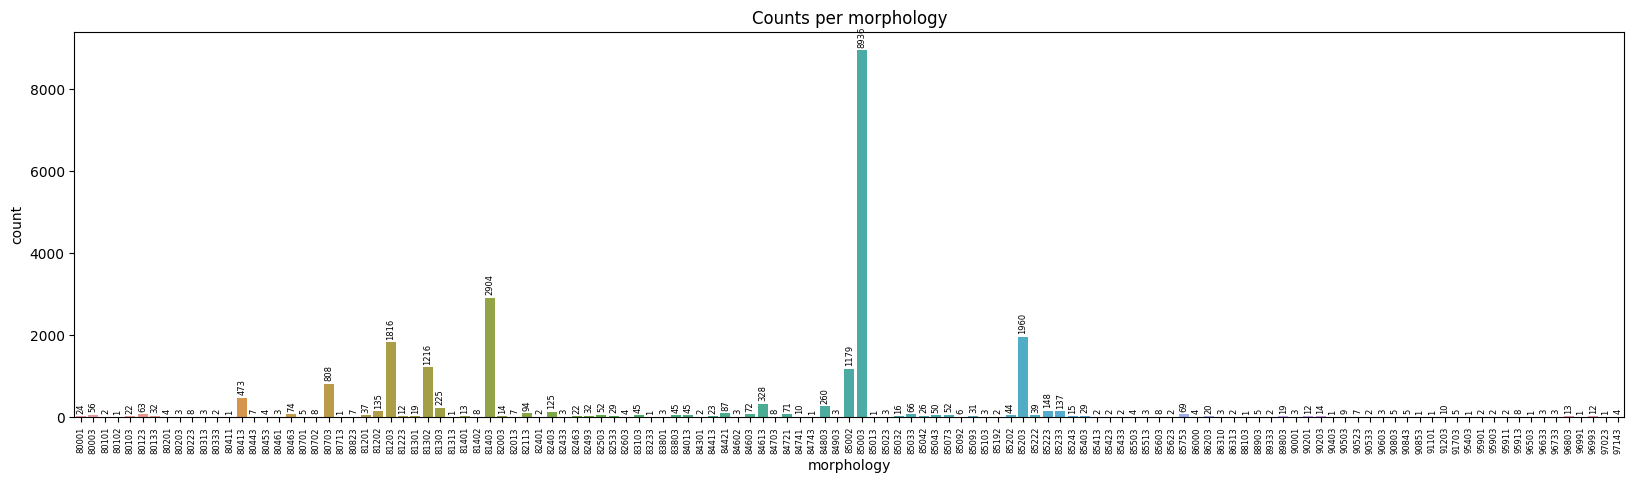

In [8]:
plot_column_count(train_valid_data, "morphology", rotate_xticks=True, figsize=(20, 5), fontsize=6)

In [9]:
test_data_year = df.loc[test_time_idx]
test_data_year.reset_index(drop=True, inplace=True)
all_classes_testtime = test_data_year["morphology"].unique()
n_reports_testtime_old = len(test_data_year)    # to compare after processing (then: "new")
print("Number of reports in testyear data:", len(test_data_year))
print(f"All classes in testset (=after {date}) set: {len(all_classes_testtime)}")


Number of reports in testyear data: 6924
All classes in testset (=after 2023-03-15) set: 82


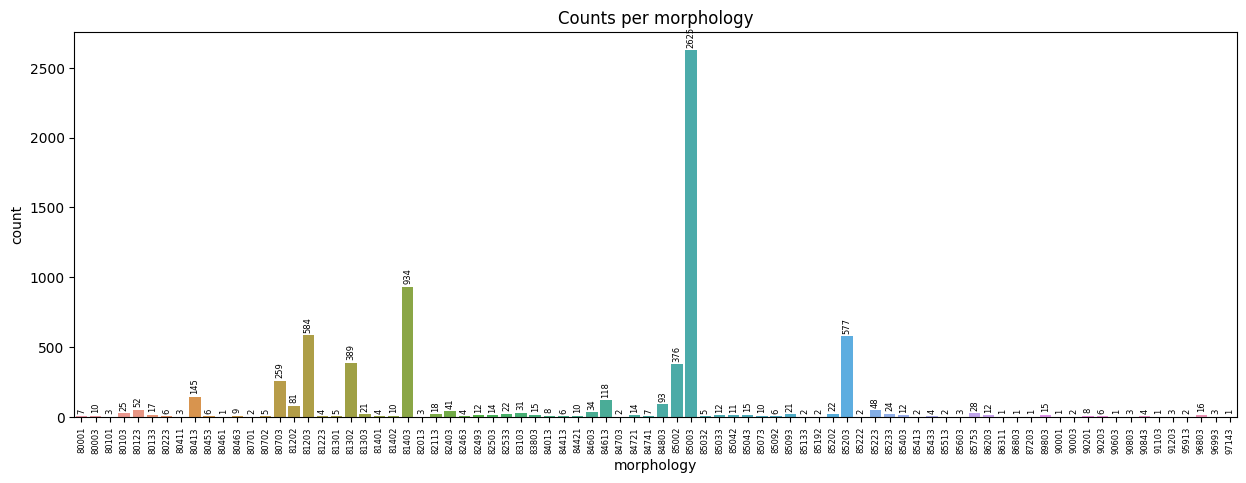

In [10]:
plot_column_count(test_data_year, "morphology", rotate_xticks=True, figsize=(15, 5), fontsize=6)

#### Step 1: Keep only classes that occurr both in train+valid and test set.
Intersection of train+valid & test set -> remove reports with classes that are not in both sets

In [11]:
# remove all classes that are not train+valid & testset
intersection_classes_train_valid_test = list(set(all_classes_trainvalid).intersection(set(all_classes_testtime)))
print(f"Classes that are in train+valid AND testtime sets: {len(intersection_classes_train_valid_test)}")


train_valid_data = train_valid_data[train_valid_data["morphology"].isin(intersection_classes_train_valid_test)].reset_index(drop=True, inplace=False)
test_data_year = test_data_year[test_data_year["morphology"].isin(intersection_classes_train_valid_test)].reset_index(drop=True, inplace=False)

print(f"Updated: Reports in train+valid data: {len(train_valid_data)} (removed {n_reports_train_valid_old-len(train_valid_data)} reports)")
print(f"Updated: Reports in testtime data: {len(test_data_year)} (removed {n_reports_testtime_old-len(test_data_year)} reports)")

assert set(train_valid_data["morphology"].unique()) == set(intersection_classes_train_valid_test)
assert set(test_data_year["morphology"].unique()) == set(intersection_classes_train_valid_test)

Classes that are in train+valid AND testtime sets: 76
Updated: Reports in train+valid data: 22219 (removed 191 reports)
Updated: Reports in testtime data: 6916 (removed 8 reports)


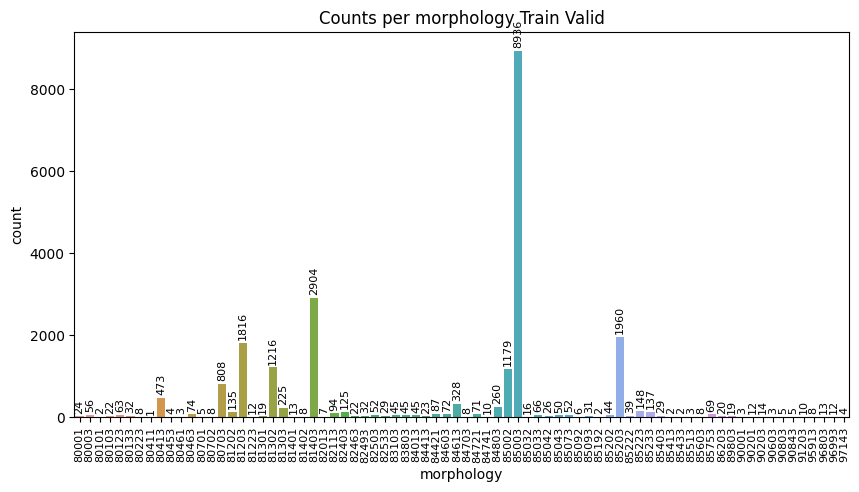

In [12]:
plot_column_count(train_valid_data, "morphology", rotate_xticks=True, fontsize=8, title_suffix=" Train Valid")

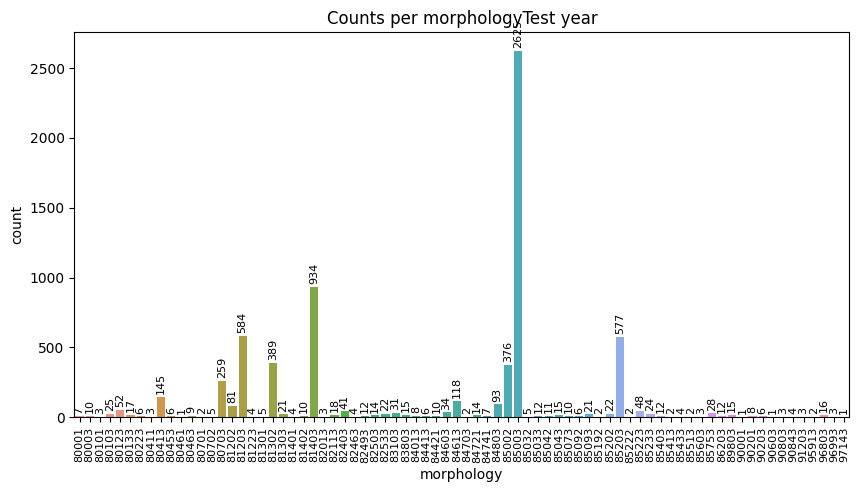

In [13]:
plot_column_count(test_data_year, "morphology", rotate_xticks=True, fontsize=8, title_suffix="Test year")

In [14]:
print(f"classes in train valid and test set: ", len(intersection_classes_train_valid_test))

classes in train valid and test set:  76


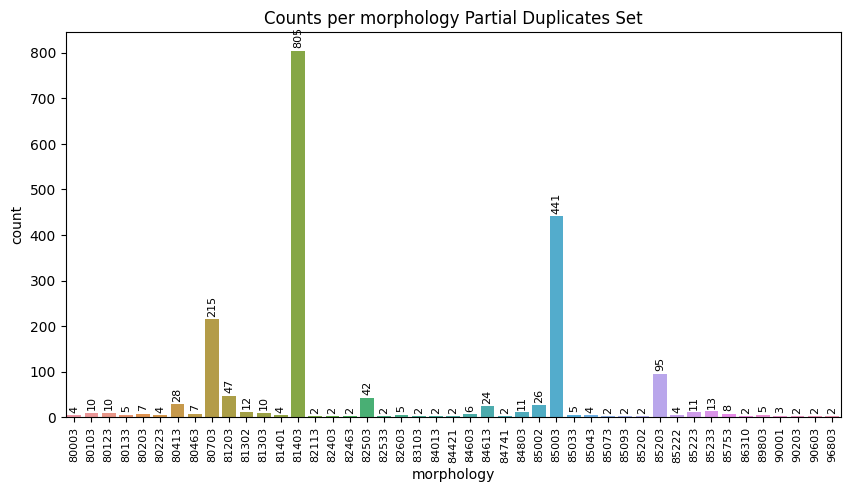

In [15]:
plot_column_count(df_partdup, "morphology", rotate_xticks=True, fontsize=8, title_suffix=" Partial Duplicates Set")

## Check large and small classes

In [16]:
# based on parameters that are set in beginning of the file
large_train_classes = []
small_train_classes = []
for code, value in train_valid_data["morphology"].value_counts().items():
    if value >= min_train:
        large_train_classes.append(code)
    else:
        small_train_classes.append(code)
print(10*"-")
print("TRAIN+VALID")
print("Large classes: ", len(large_train_classes))
print("Small classes: ", len(small_train_classes))
print("**NOTE**:\n",
      "\tThe large classes in the training set are the ones that will be used for classification.\n",
      "\tThe small classes will be merged to 'other', also in the testset.\n",
      "\tFor the Partdup Set, the small training classes are also merged, but there might be classes with <10")  # the part dup set (=partial duplicates), were not further explored later in the thesis

large_test_classes = []
small_test_classes = []
for code, value in test_data_year["morphology"].value_counts().items():
    if value >= min_test:
        large_test_classes.append(code)
    else:
        small_test_classes.append(code)
print(10*"-")
print(f"TEST PERIOD {date}")
print("Large classes: ", len(large_test_classes))
print("Small classes: ", len(small_test_classes))
print(10*"-")

print("** NOTE **:\n",
      f"\tSmall in train and testset: {set(small_train_classes).intersection(small_test_classes)}\n",
      f"\tLarge in train and testset: {set(large_train_classes).intersection(large_test_classes)}\n",
      f"\tLarge in training but small in the testset: {set(large_train_classes).intersection(small_test_classes)}\n",
      f"\tSmall in training but large in the testset: {set(small_train_classes).intersection(large_test_classes)}\n")


----------
TRAIN+VALID
Large classes:  15
Small classes:  61
**NOTE**:
 	The large classes in the training set are the ones that will be used for classification.
 	The small classes will be merged to 'other', also in the testset.
 	For the Partdup Set, the small training classes are also merged, but there might be classes with <10
----------
TEST PERIOD 2023-03-15
Large classes:  23
Small classes:  53
----------
** NOTE **:
 	Small in train and testset: {80001, 80003, 80133, 84741, 85513, 90001, 81301, 85403, 80411, 82463, 96803, 85413, 85032, 85033, 95913, 84013, 85042, 85043, 90803, 85433, 86203, 82493, 84413, 80702, 80701, 82113, 91203, 84421, 80453, 82503, 81223, 85192, 89803, 80461, 80463, 85073, 90201, 83803, 90203, 90843, 82013, 80223, 84703, 96993, 85603, 85092, 80101, 85222, 90603, 84721, 97143, 81401, 81402}
 	Large in train and testset: {84803, 82403, 84613, 85223, 85002, 85003, 85233, 81202, 81203, 85203, 81302, 81303, 81403, 80413, 80703}
 	Large in training but small in t

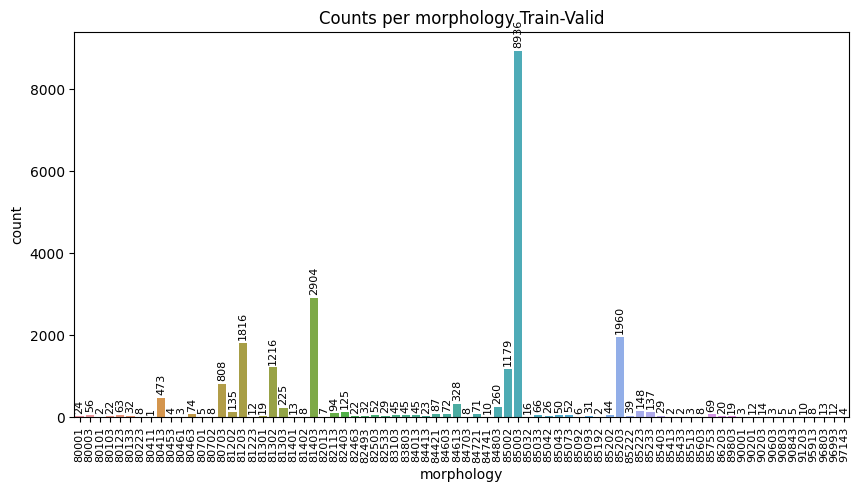

In [17]:
plot_column_count(train_valid_data, "morphology", rotate_xticks=True, fontsize=8, title_suffix=" Train-Valid")

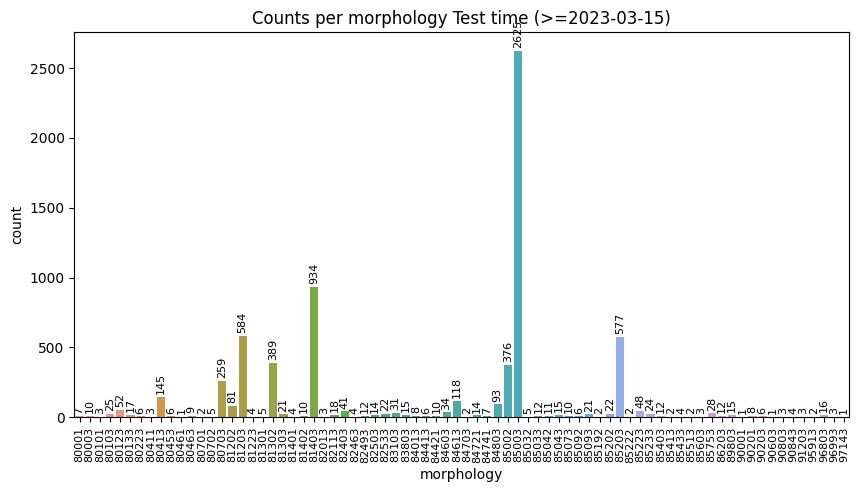

In [18]:
plot_column_count(test_data_year, "morphology", rotate_xticks=True, fontsize=8,title_suffix=f" Test time (>={date})")

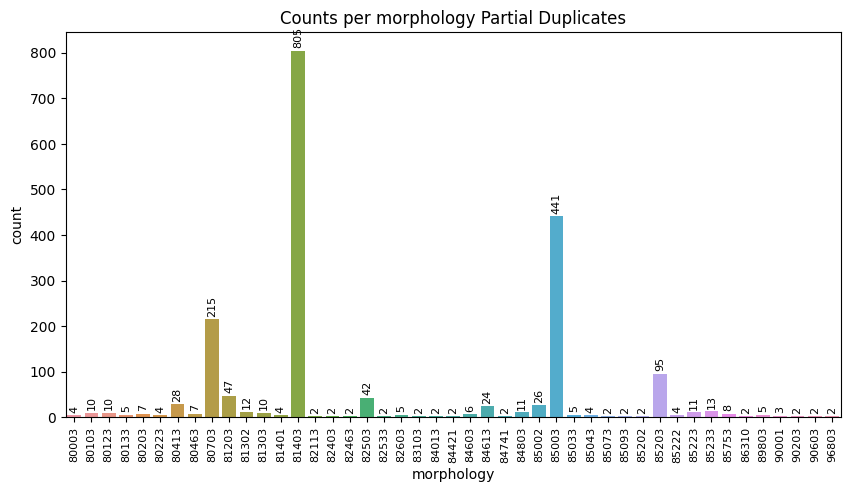

In [19]:
plot_column_count(df_partdup, "morphology", rotate_xticks=True, fontsize=8, title_suffix=" Partial Duplicates")

In [20]:
#########################

### Merge all codes that are NOT large in both train+valid AND testtime to "other" class

In [21]:
# get the classes when splitting morph codes into histology + behavior
# these are used to easily replace the codes in the dfs later on

classes_morph = set(large_train_classes).intersection(set(large_test_classes))
print("Large classes in train: ", len(large_train_classes))
print("Large classes in test: ", len(large_test_classes))
print("Intersection between the large train and test classes (= final number of classes) + 1 for 'other': ", len(classes_morph))
classes_hist = list(set([int(str(code)[:-1]) for code in classes_morph]))
classes_behavior = list(set([int(str(code)[-1]) for code in classes_morph]))

print(f"{len(classes_morph)} classes for Morphology + 1 for 'other'")
print(f"{len(classes_hist)} classes for Histology + 1 for 'other'")
print(f"{len(classes_behavior)} classes for Behavior + 1 for 'other'")

Large classes in train:  15
Large classes in test:  23
Intersection between the large train and test classes (= final number of classes) + 1 for 'other':  15
15 classes for Morphology + 1 for 'other'
12 classes for Histology + 1 for 'other'
2 classes for Behavior + 1 for 'other'


In [22]:
dummy_class_morph = 99999
dummy_class_hist = 9999
dummy_class_behav = 9
dummy_class_grade = 9   # for completeness, but redundant since grade is completely removed from experiments

col_name_morph = "morphology"    # counts in this column will be used to split sets (this excludes the 6th value for grade!)
col_name_hist = "histology"
col_name_behav = "behavior"
col_name_site = "site"
col_name_grade = "grade"    # for completeness, but redundant since grade is completely removed from experiment

In [23]:
# merge classes to "other" class in all relevant columns of train valid set
train_valid_data_merged = train_valid_data.copy(deep=True)
train_valid_data_merged["morphology"] = train_valid_data_merged["morphology"].apply(lambda x: x if x in classes_morph else dummy_class_morph)
train_valid_data_merged["histology"] = np.where(train_valid_data_merged["morphology"] == dummy_class_morph, dummy_class_hist, train_valid_data_merged["histology"])
train_valid_data_merged["behavior"] = np.where(train_valid_data_merged["morphology"] == dummy_class_morph, dummy_class_behav, train_valid_data_merged["behavior"])
# maybe redundant since I exclude grade completely from experiments
train_valid_data_merged["grade"] = np.where(train_valid_data_merged["morphology"] == dummy_class_morph, dummy_class_grade, train_valid_data_merged["grade"])


assert train_valid_data_merged["behavior"].value_counts()[dummy_class_behav] == train_valid_data_merged["morphology"].value_counts()[dummy_class_morph] == train_valid_data_merged["histology"].value_counts()[dummy_class_hist]

n_reports_dummy_class_trainvalid = train_valid_data_merged["morphology"].value_counts()[dummy_class_morph]
print(f"Reports that are merged into 'other' class {dummy_class_morph} in train+valid: {n_reports_dummy_class_trainvalid}  ({round(n_reports_dummy_class_trainvalid / len(train_valid_data_merged), ndigits=4)*100}%)")
print(f"Number of classes after merging to 'other':")
print(f"Morphology {len(train_valid_data_merged[col_name_morph].unique())}")
print(f"Histology {len(train_valid_data_merged[col_name_hist].unique())}")
print(f"Behavior {len(train_valid_data_merged[col_name_behav].unique())}")

Reports that are merged into 'other' class 99999 in train+valid: 1569  (7.06%)
Number of classes after merging to 'other':
Morphology 16
Histology 13
Behavior 3


In [24]:
# merge classes to "other" class in relevant columns of testset
test_data_year_merged = test_data_year.copy(deep=True)
test_data_year_merged["morphology"] = test_data_year_merged["morphology"].apply(lambda x: x if x in classes_morph else dummy_class_morph)

test_data_year_merged["histology"] = np.where(test_data_year_merged["morphology"] == dummy_class_morph, dummy_class_hist, test_data_year_merged["histology"])
test_data_year_merged["behavior"] = np.where(test_data_year_merged["morphology"] == dummy_class_morph, dummy_class_behav, test_data_year_merged["behavior"])

assert test_data_year_merged["behavior"].value_counts()[dummy_class_behav] == test_data_year_merged["morphology"].value_counts()[dummy_class_morph] == test_data_year_merged["histology"].value_counts()[dummy_class_hist]


n_reports_dummy_class = test_data_year_merged["morphology"].value_counts()[dummy_class_morph]
print(f"Reports that are merged into 'other' class {dummy_class_morph} in test period: {n_reports_dummy_class} ({round(n_reports_dummy_class / len(test_data_year_merged), ndigits=4)*100}%)")
print(f"Number of classes after merging to 'other':")
print(f"Morphology {len(test_data_year_merged[col_name_morph].unique())}")
print(f"Histology {len(test_data_year_merged[col_name_hist].unique())}")
print(f"Behavior {len(test_data_year_merged[col_name_behav].unique())}")

Reports that are merged into 'other' class 99999 in test period: 601 (8.690000000000001%)
Number of classes after merging to 'other':
Morphology 16
Histology 13
Behavior 3


## Save datasets

In [25]:
len(train_valid_data_merged)

22219

In [26]:
len(test_data_year_merged)

6916

In [27]:
one_split_folder = os.path.join(data_splits_folder, f"train{min_train}_test{min_test}_date{date}_data")
create_folder_if_not_exists(one_split_folder)

output_sets = [("train_valid", train_valid_data_merged),
               ("test", test_data_year_merged),]

for filename, dataset in output_sets:
    dataset.to_pickle(os.path.join(one_split_folder, f"{filename}.pkl"))
    dataset.to_csv(os.path.join(one_split_folder, f"{filename}.csv"), encoding="utf-8")

<20241028_datasplits\train120_test20_date2023-03-15_data> does not yet exist -> create local folder...
<20241028_datasplits\train120_test20_date2023-03-15_data> exists:  True


## Distributions within the sets
with min 120 reports per morphology class in Train&Val set and min 20 per class in the Test set

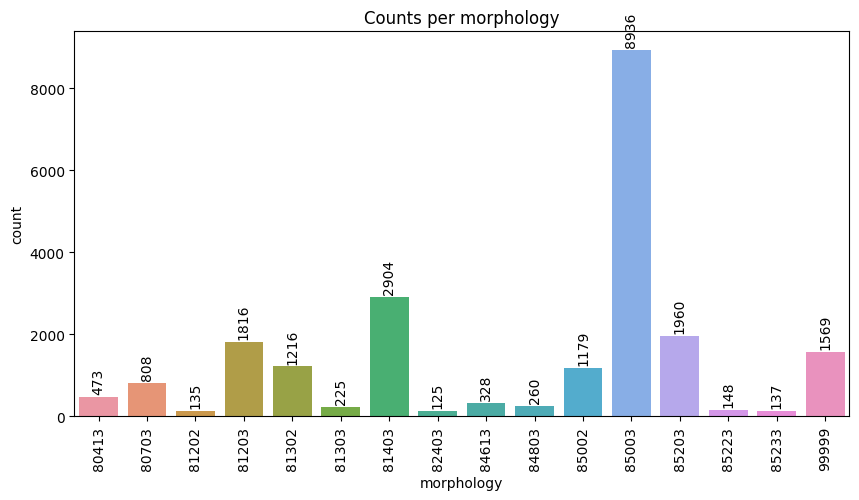

In [28]:
plot_column_count(train_valid_data_merged, "morphology", rotate_xticks=True)


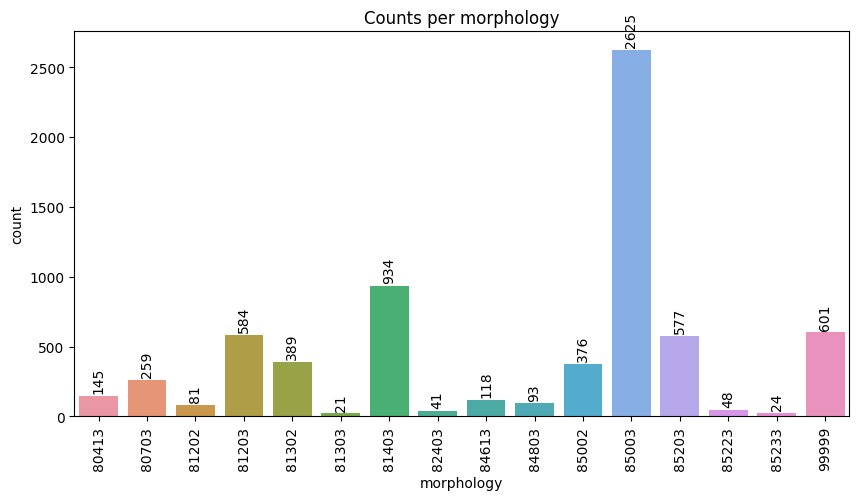

In [29]:
plot_column_count(test_data_year_merged, "morphology",  rotate_xticks=True)
